In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import models
from models import NeuralNetwork as nn
%matplotlib inline

In [2]:
plt.style.use("grayscale")
plt.style.use("seaborn-whitegrid")

# 適当なデータを生成する

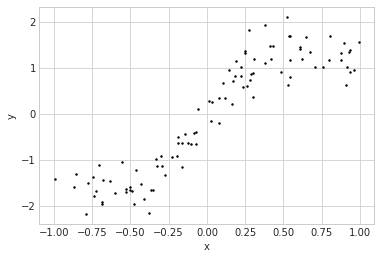

In [3]:
N = 100
sigma2_true = 0.1

# x = np.random.normal(size=N)
x = np.random.uniform(low=-1, high=1, size=N)
func = lambda x: np.sin(x*3) + x - 0.3*x**2
y = func(x) + np.random.normal(scale=np.sqrt(sigma2_true), size=N)

plt.scatter(x, y, s=2, c="k")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# 1節：線形回帰モデル

In [4]:
# 基底関数による変換
polydim = 10
Phi = models.PolyBaseFunction(x, dims=polydim)

# モデル定義
lm = models.LinearRegression(y, Phi)

In [5]:
xmin, xmax = x.min(), x.max()
xline = np.linspace(xmin, xmax, num=50)
philine = models.PolyBaseFunction(xline, dims=polydim)

## 各手法による推定

※ベイズ推論以外の場合は，予測区間はxに寄らず一定になります

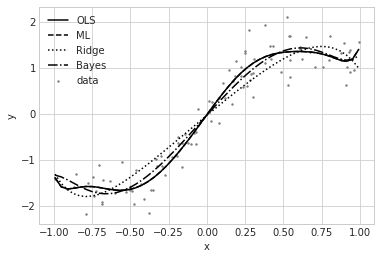

In [6]:
# 推定
lm.fit_OLS()
lm.fit_ML()
lm.fit_Ridge(alpha=1)
lm.fit_Bayes(sigma2=sigma2_true, prior_cov=np.eye(polydim+1))

# グラフ描画（予測を含む）
plt.scatter(x, y, s=2, c="gray", label="data")
plt.plot(xline, lm.predict_OLS(philine), label="OLS", linestyle="-", c="k")#c="Blue")
plt.plot(xline, lm.predict_ML(philine), label="ML", linestyle="--", c="k")#c="Purple")
plt.plot(xline, lm.predict_Ridge(philine), label="Ridge", linestyle=":", c="k")#c="Orange")

mean, var = lm.predict_Bayes(philine)
plt.plot(xline, mean, label="Bayes", linestyle="-.", c="k")#c="Red")
# plt.fill_between(xline, mean - 0.5*np.sqrt(var), mean + 0.5*np.sqrt(var), alpha=0.3, label="Bayes Std", color="Red")

plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.savefig("../draft/img/LinearRegressions.png", dpi=300)
plt.show()

## 推定の安定性を見る

In [22]:
def plot(ax, xline, pred, color, alpha, linestyle=None):
    ax.plot(xline, pred, c=color, alpha=alpha, linestyle=linestyle)

サンプル数:30


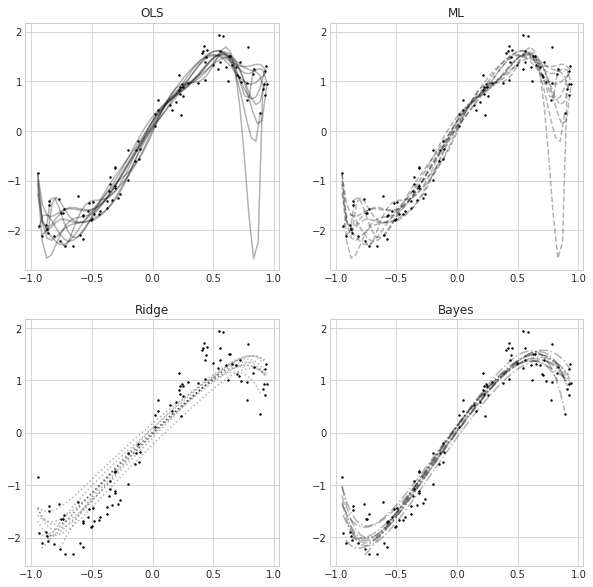

In [29]:
n_iter = 10
rate_sample = 0.3
print("サンプル数:{}".format(int(N*rate_sample)))

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(221)
ax1.set_title("OLS")
ax2 = fig.add_subplot(222)
ax2.set_title("ML")
ax3 = fig.add_subplot(223)
ax3.set_title("Ridge")
ax4 = fig.add_subplot(224)
ax4.set_title("Bayes")

for i in range(n_iter):
    mask = np.random.choice(range(N), size=int(N*rate_sample))
    x_sample = x[mask]
    Phi_sample = models.PolyBaseFunction(x_sample, dims=polydim)
    y_sample = y[mask]
    lm_sample = models.LinearRegression(y=y_sample, Phi=Phi_sample)
    
    lm_sample.fit_OLS()
    lm_sample.fit_ML()
    lm_sample.fit_Ridge(alpha=1)
    lm_sample.fit_Bayes(sigma2=sigma2_true, prior_cov=np.eye(polydim+1))

    xline_sample = np.linspace(x_sample.min(), x_sample.max(), num=50)
    philine_sample = models.PolyBaseFunction(xline_sample, dims=polydim)
    
    pred = lm_sample.predict_OLS(philine_sample)
    plot(ax1, xline_sample, pred, "k", 0.3, "-")
    #plot(ax1, xline_sample, pred, "Blue", 0.3)
    pred = lm_sample.predict_ML(philine_sample)
    plot(ax2, xline_sample, pred, "k", 0.3, "--")
    #plot(ax2, xline_sample, pred, "Purple", 0.3)
    pred = lm_sample.predict_Ridge(philine_sample)
    plot(ax3, xline_sample, pred, "k", 0.3, ":")
    #plot(ax3, xline_sample, pred, "Orange", 0.3)
    pred, _ = lm_sample.predict_Bayes(philine_sample)
    plot(ax4, xline_sample, pred, "k", 0.3, "-.")
    #plot(ax4, xline_sample, pred, "Red", 0.3)
    
ax1.scatter(x, y, s=2, c="k")
ax2.scatter(x, y, s=2, c="k")
ax3.scatter(x, y, s=2, c="k")
ax4.scatter(x, y, s=2, c="k")

plt.savefig("../draft/img/EstimationStable.png", dpi=300)
plt.show()

# 2節：分位点回帰
## 中央値回帰とその安定性

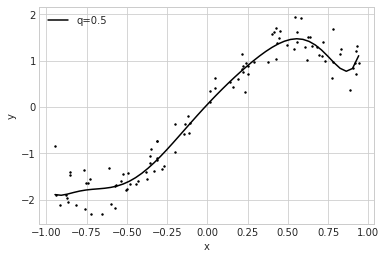

In [26]:
qr = models.QuantileRegression(y, Phi, quantile=0.5)
qr.fit()

plt.scatter(x, y, s=2, c="k")
plt.plot(xline, qr.predict(philine), label="q=0.5", c="k")#"Blue")

plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

サンプル数:30


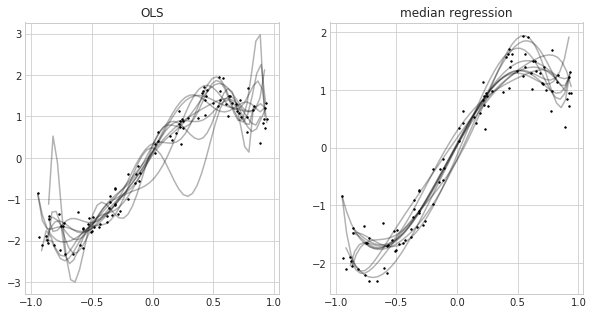

In [30]:
n_iter = 10
rate_sample = 0.3
print("サンプル数:{}".format(int(N*rate_sample)))

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax1.set_title("OLS")
ax2 = fig.add_subplot(122)
ax2.set_title("median regression")
for i in range(n_iter):
    mask = np.random.choice(range(N), size=int(N*rate_sample))
    x_sample = x[mask]
    Phi_sample = models.PolyBaseFunction(x_sample, dims=polydim)
    y_sample = y[mask]
    
    y_sample[-1] += np.random.normal(scale=2*np.std(y_sample)) # 外れ値の挿入
    
    lm_sample = models.LinearRegression(y_sample, Phi_sample)
    lm_sample.fit_OLS()
    qr_sample = models.QuantileRegression(y_sample, Phi_sample, quantile=0.5)
    qr_sample.fit()
    
    xline_sample = np.linspace(x_sample.min(), x_sample.max(), num=50)
    philine_sample = models.PolyBaseFunction(xline_sample, dims=polydim)

    pred = lm_sample.predict_OLS(philine_sample)
    plot(ax1, xline_sample, pred, color="k", alpha=0.3)
    #plot(ax1, xline_sample, pred, color="Blue", alpha=0.3)
    
    pred = qr_sample.predict(philine_sample)
    plot(ax2, xline_sample, pred, color="k", alpha=0.3)
    #plot(ax2, xline_sample, pred, color="Blue", alpha=0.3)

ax1.scatter(x, y, s=2, c="k")
ax2.scatter(x, y, s=2, c="k")

plt.savefig("../draft/img/OLSvsMedianRegression.png", dpi=300)
plt.show()

## 条件付き分布の特定

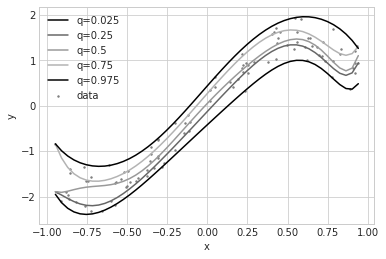

In [33]:
for q in [0.025, 0.25, 0.5, 0.75, 0.975]:
    qr = models.QuantileRegression(y, Phi, quantile=q)
    qr.fit()

    plt.plot(xline, qr.predict(philine), label="q={}".format(q))

plt.scatter(x, y, s=2, c="gray", label="data")
    
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

plt.savefig("../draft/img/QuantileRegression.png", dpi=300)
plt.show()

# 3節：ニューラルネットワーク

In [34]:
mlp = nn.utils.MLP(input_dim=1, n_hidden=1) # MLP(Multi-Layer Perceptron)
optimizer = nn.optimizer.SGD(lr=0.01)

100%|██████████| 1000/1000 [00:00<00:00, 1538.07it/s]


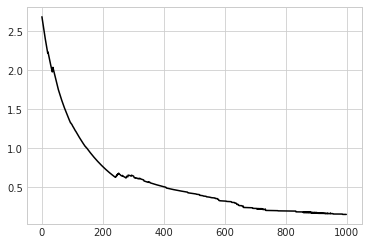

In [35]:
loss = []
for i in tqdm(range(1000)):
    pred = mlp(x=x.reshape((-1,1))) # 前向き処理
    loss.append(mlp.get_loss(pred, obs=y)) # 損失計算
    mlp.backward() # 後ろ向き処理（誤差逆伝播による勾配計算）
    mlp.update(optimizer) # 勾配降下法による更新
plt.plot(loss);

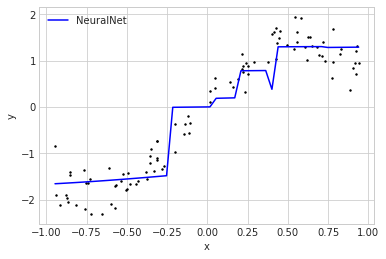

In [36]:
plt.scatter(x, y, s=2, c="k")
plt.plot(xline, mlp.predict(xline.reshape((-1,1))), label="NeuralNet", c="Blue")

plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

## 大規模データのための確率的勾配降下法

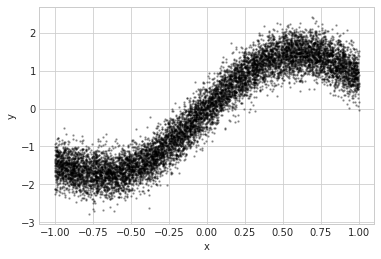

In [37]:
N = 10000
sigma2_true = 0.1

# x = np.random.normal(size=N)
x = np.random.uniform(low=-1, high=1, size=N)
func = lambda x: np.sin(x*3) + x - 0.3*x**2
y = func(x) + np.random.normal(scale=np.sqrt(sigma2_true), size=N)

plt.scatter(x, y, s=2, c="k", alpha=0.3)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [46]:
# 活性化関数をReLU, パラメータの初期化をHeの方法で行い，隠れ層を増やした
mlp = nn.utils.MLP(input_dim=1, n_hidden=5, n_units=100, activation=nn.activation.ReLU, init="He")
optimizer = nn.optimizer.SGD(lr=0.01)
minibatch = nn.utils.MinibatchGenerator(y, x.reshape((-1,1)), batchsize=64)

100%|██████████| 2000/2000 [00:39<00:00, 50.45it/s]


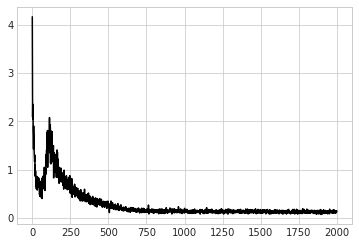

In [47]:
loss = []
for i in tqdm(range(2000)):
    y_mini, x_mini = minibatch() # ミニバッチの抽出
    pred = mlp(x=x_mini)
    loss.append(mlp.get_loss(pred, obs=y_mini))
    mlp.backward()
    mlp.update(optimizer)
plt.plot(loss);

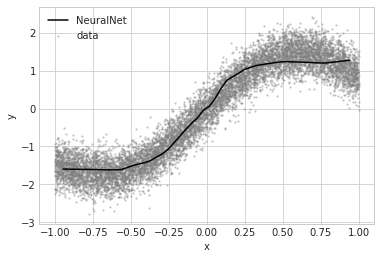

In [49]:
plt.scatter(x, y, s=2, c="gray", alpha=0.3, label="data")
plt.plot(xline, mlp.predict(xline.reshape((-1,1))), label="NeuralNet", c="k")#c="Orange")

plt.xlabel("x")
plt.ylabel("y")
plt.legend()

plt.savefig("../draft/img/MLP.png", dpi=300)
plt.show()